# Graph Geometry

In [158]:
from common_variables import *
DATA['paths']
resave_figures = False

In [2]:
def loadMetabolicNetworks(directory):
    G_list = []
    G_names = []
    
    # Find all node table files
    node_files = glob.glob(os.path.join(directory, 'NodeTable_*.csv'))
    if not node_files:
        print(f"No node table files found in directory: {directory}")
        return [], [], []
    
    print(f"Found {len(node_files)} node table files.\n")
    
    # Load each model
    for node_file in sorted(node_files):
        model_name = re.search(r'NodeTable_(.+)\.csv', node_file).group(1)
        edge_file = os.path.join(directory, f'EdgeTable_{model_name}.csv')
        
        if not os.path.exists(edge_file):
            print(f"Warning: No edge table found for {model_name}")
            continue
        
        node_df = pd.read_csv(node_file)
        edge_df = pd.read_csv(edge_file)
        edge_df['ReactionName'] = edge_df['ReactionName'].fillna(edge_df['ReactionID'])

        # Reverse edges where flux is negative
        edge_df['AdjustedSource'] = edge_df.apply(lambda row: row['Target'] if row['Flux'] < 0 else row['Source'], axis=1)
        edge_df['AdjustedTarget'] = edge_df.apply(lambda row: row['Source'] if row['Flux'] < 0 else row['Target'], axis=1)
        edge_df['AdjustedFlux'] = edge_df['Flux'].abs()  # Convert flux to positive after flipping

        # Create a MultiDiGraph to preserve all edges
        G = nx.MultiDiGraph()
        
        # Add nodes with metabolite names as attributes
        for _, row in node_df.iterrows():
            G.add_node(row['NodeID'], MetaboliteID=row['MetaboliteID'], MetaboliteName=row['MetaboliteName'])
        
        # Add edges to the graph, keeping all distinct reactions
        for _, row in edge_df.iterrows():
            G.add_edge(
                row['AdjustedSource'], row['AdjustedTarget'], key=row['ReactionID'],
                ReactionID=row['ReactionID'], 
                ReactionName=row.get('ReactionName', 'Undefined Rxn Name'),
                weight=row['AdjustedFlux']
            )

        G_list.append(G)
        G_names.append(model_name)
        print(f"Loaded model {model_name} with {len(G.nodes)} nodes and {G.number_of_edges()} total edges.")

    return G_list, G_names


def loadMetabolicNetworksCompact(directory):
    G_list = []
    G_names = []
    
    # Find all node table files
    node_files = glob.glob(os.path.join(directory, 'NodeTable_*.csv'))
    if not node_files:
        print(f"No node table files found in directory: {directory}")
        return [], [], []
    
    print(f"Found {len(node_files)} node table files.\n")
    
    # Load each model
    for node_file in sorted(node_files):
        model_name = re.search(r'NodeTable_(.+)\.csv', node_file).group(1)
        edge_file = os.path.join(directory, f'EdgeTable_{model_name}.csv')
        
        if not os.path.exists(edge_file):
            print(f"Warning: No edge table found for {model_name}")
            continue
        
        node_df = pd.read_csv(node_file)
        edge_df = pd.read_csv(edge_file)


        # Reverse edges where flux is negative
        edge_df['AdjustedSource'] = edge_df.apply(lambda row: row['Target'] if row['Flux'] < 0 else row['Source'], axis=1)
        edge_df['AdjustedTarget'] = edge_df.apply(lambda row: row['Source'] if row['Flux'] < 0 else row['Target'], axis=1)
        edge_df['AdjustedFlux'] = edge_df['Flux'].abs()  # Convert flux to positive after flipping

        # Group by the new source-target pairs and sum flux
        grouped_edges = edge_df.groupby(['AdjustedSource', 'AdjustedTarget'], as_index=False).agg({
            'ReactionID': lambda x: ';'.join(x.astype(str)),  # Combine reaction IDs
            'ReactionName': lambda x: ';'.join(x.astype(str)),  # Combine reaction names
            'AdjustedFlux': 'sum'  # Sum flux values
        })

        # Create a directed graph
        G = nx.DiGraph()
        
        # Add nodes with metabolite names as attributes
        for _, row in node_df.iterrows():
            G.add_node(row['NodeID'], MetaboliteID=row['MetaboliteID'], MetaboliteName=row['MetaboliteName'])
        
        # Add edges to the graph
        for _, row in grouped_edges.iterrows():
            G.add_edge(
                row['AdjustedSource'], row['AdjustedTarget'], 
                ReactionID=row['ReactionID'], 
                ReactionName=row.get('ReactionName', 'Undefined Rxn Name'),
                weight=row['AdjustedFlux']
            )

        G_list.append(G)
        G_names.append(model_name)
        print(f"Loaded model {model_name} with {len(G.nodes)} nodes and {len(G.edges)} unique edges from total of {len(edge_df)} edges.")
    
    return G_list, G_names

G_list, G_names = loadMetabolicNetworks(DATA['paths']['dir_nodesedges']) 
G_names = [name.replace('Cancer_', 'Epithelial_') for name in G_names]

G_list_compact, G_names_compact = loadMetabolicNetworksCompact(DATA['paths']['dir_nodesedges']) 
G_names_compact = [name.replace('Cancer_', 'Epithelial_') for name in G_names_compact]

Found 22 node table files.

Loaded model Cancer_Normal_Malignant with 4134 nodes and 40323 total edges.
Loaded model Cancer_Tumor_Malignant with 4143 nodes and 41722 total edges.
Loaded model Fibroblast_Normal_CD73+ with 3740 nodes and 35633 total edges.
Loaded model Fibroblast_Normal_DES+ with 3407 nodes and 32961 total edges.
Loaded model Fibroblast_Normal_FAP+ with 3843 nodes and 36331 total edges.
Loaded model Fibroblast_Normal_FGFR2+ with 3842 nodes and 36185 total edges.
Loaded model Fibroblast_Normal_ICAM1+ with 3729 nodes and 36882 total edges.
Loaded model Fibroblast_Normal_ICAM1- with 3742 nodes and 38461 total edges.
Loaded model Fibroblast_Normal_MFAP5+ with 3717 nodes and 33600 total edges.
Loaded model Fibroblast_Tumor_CD73+ with 3761 nodes and 31701 total edges.
Loaded model Fibroblast_Tumor_DES+ with 3535 nodes and 33331 total edges.
Loaded model Fibroblast_Tumor_FAP+ with 3799 nodes and 39001 total edges.
Loaded model Fibroblast_Tumor_FGFR2+ with 3564 nodes and 34387 t

In [3]:
def calculate_fractal_dimension_nx(network, moment_values, use_weights=False, show_progress=True, distance_precision=4):

    # Lists and sets to store distance information from each node
    node_distances = []
    unique_radii = set()
    total_nodes = nx.number_of_nodes(network)
    
    # Parameter for the shortest path algorithm
    weight_param = 'weight' if use_weights else None 
    
    # Calculate shortest paths from each node to all others
    if show_progress:
        print(f"Calculating distances for {total_nodes} nodes...", flush=True)
    
    node_counter = 0
    for current_node in list(network.nodes()):
        node_counter += 1
        if show_progress and (node_counter % 500 == 0 or node_counter == total_nodes):
            print(f"  Processing node {node_counter}/{total_nodes} ({node_counter/total_nodes*100:.1f}%)", end="\r", flush=True)
        
        distances = []
        
        # Calculate shortest paths using NetworkX
        path_lengths = nx.single_source_dijkstra_path_length(network, current_node, weight=weight_param)
        
        # Filter out self-loops (zero distance)
        for target, dist in path_lengths.items():
            if current_node != target and dist > 0:
                distances.append(dist)
        
        distances.sort()
        
        # Round distances according to specified precision
        if distance_precision == 0:
            # Round up to nearest integer if precision is 0
            distances = [math.ceil(d) for d in distances]
        else:
            # Otherwise round to specified decimal places
            distances = [round(d, distance_precision) for d in distances]
            
        # Count frequency of each distance value
        distance_counts = Counter(distances)
        # Add any new distance values to our set of unique radii
        unique_radii.update(distance_counts.keys())
        # Store the distance distribution for this node
        node_distances.append(distance_counts)
    
    if show_progress:
        print("\nBuilding distance matrix...", flush=True)
    
    # Handle case where no valid distances were found (disconnected graph)
    if not unique_radii:
        print("Warning: No valid distances found. Graph may be disconnected.")
        return [0] * len(moment_values)
    
    # Convert set of unique distances to sorted numpy array for consistent indexing
    radii_array = np.array(sorted(list(unique_radii)))
    
    # Create matrix where each cell [i,j] contains number of nodes
    # within radius j from node i
    distance_matrix = np.ones((len(node_distances), len(radii_array)))
    for i, counts in enumerate(node_distances):
        for j, radius in enumerate(radii_array):
            # Sum up counts of all distances less than or equal to current radius
            distance_matrix[i, j] += sum(count for dist, count in counts.items() if dist <= radius)

    # Get network diameter (maximum distance between any two nodes)
    network_diameter = radii_array[-1]
    partition_sums = []
    
    # Calculate partition sums for each moment value q
    # This measures how node density scales with distance
    if show_progress:
        print(f"Calculating partition sums for {len(moment_values)} q-values...", flush=True)
    
    for q_idx, q in enumerate(moment_values):
        if show_progress and (q_idx % 50 == 0 or q_idx == len(moment_values) - 1):
            print(f"  Processing q-value {q_idx+1}/{len(moment_values)} ({(q_idx+1)/len(moment_values)*100:.1f}%)", end="\r", flush=True)
        
        # Normalize by maximum count for each node and raise to power q
        normalized_matrix = np.power(distance_matrix / distance_matrix[:, -1, None], q)
        # Sum over all nodes to get partition function
        partition_sums.append(np.sum(normalized_matrix, axis=0))
    
    if show_progress:
        print("\nCalculating scaling exponents...", flush=True)
    
    # Calculate scaling exponents (slopes in log-log plot)
    scaling_exponents = []
    
    # Calculate without plotting
    for idx, q in enumerate(moment_values):
        log_radii = np.log(radii_array/network_diameter)
        log_partition = np.log(partition_sums[idx])
        slope, intercept, *_, _ = stats.linregress(log_radii, log_partition)
        scaling_exponents.append(slope)
    
    if show_progress:
        print("Fractal dimension calculation complete.", flush=True)
    
    return scaling_exponents

def compute_spectrum(scaling_exponents, moment_values):  
    # Calculate Hölder exponents (local scaling properties)
    holder_exponents = []
    spectrum_values = []
    
    for i in range(1, len(moment_values)):
        alpha = (scaling_exponents[i] - scaling_exponents[i-1]) / (moment_values[i] - moment_values[i-1])
        holder_exponents.append(alpha)
    
    # Calculate spectrum values (fractal dimensions)
    for j in range(len(moment_values) - 1):
        f_alpha = moment_values[j] * holder_exponents[j] - scaling_exponents[j]
        spectrum_values.append(f_alpha)
    
    # Find spectrum characteristics
    spectrum_peak = holder_exponents[np.argmax(spectrum_values)]
    spectrum_width = np.max(holder_exponents) - np.min(holder_exponents)
    
    return {
        'holder_exponents': holder_exponents,
        'spectrum_values': spectrum_values,
        'spectrum_peak': spectrum_peak,
        'spectrum_width': spectrum_width
    }

def prepare_spectrum_dataframe(G_list, G_names, moment_values=None, use_weights=True):
    # Prepare moment values (if not already prepared)
    if not moment_values:
        moment_values = [q/100 for q in range(-2000, 2001, 10)]
    
    spectrum_data = []
    
    for i, network in enumerate(G_list):
        print(f"Processing graph {i+1}/{len(G_list)}: {G_names[i]}")
        
        # Calculate scaling exponents for the network
        scaling_exponents = calculate_fractal_dimension_nx(network, moment_values, use_weights=use_weights)
        
        # Compute spectrum for current graph
        spectrum_dict = compute_spectrum(scaling_exponents, moment_values)
        spectrum_dict['scaling_exponents'] = scaling_exponents
        
        # Add graph name and additional metadata (assuming specific naming convention)
        spectrum_dict['graph_name'] = G_names[i]
        
        # These fields depend on your specific naming convention
        # Modify as needed for your graph names
        name_parts = G_names[i].split('_')
        if len(name_parts) > 0:
            spectrum_dict['maintype'] = name_parts[0]
        if len(name_parts) > 1:
            spectrum_dict['celltype'] = name_parts[-1]
        spectrum_dict['tissue'] = 'Normal' if 'Normal' in G_names[i] else 'Tumor'
        
        spectrum_data.append(spectrum_dict)
    
    # Convert to DataFrame
    df = pd.DataFrame(spectrum_data)
    
    return df


def load_spectrum_data(file_path):
    # Read the CSV file
    df = pd.read_csv(file_path) 
    if 'holder_exponents' in df.columns:
        df['holder_exponents'] = df['holder_exponents'].apply(ast.literal_eval)
    if 'spectrum_values' in df.columns:
        df['spectrum_values'] = df['spectrum_values'].apply(ast.literal_eval)
    if 'scaling_exponents' in df.columns:
        df['scaling_exponents'] = df['scaling_exponents'].apply(ast.literal_eval)
    
    return df


moment_values = [q/100 for q in range(-600, 601, 5)]

In [4]:
# Analyze and plot
# G_spectrums = prepare_spectrum_dataframe(G_list, G_names, moment_values, use_weights=False)
# G_spectrums.to_csv(f"output/graph_spectrums_without_weights.csv", index=False)

# Analyze and plot
# G_spectrums_compact = prepare_spectrum_dataframe(G_list_compact, G_list_compact, moment_values, use_weights=False)
# G_spectrums_compact.to_csv(f"output/graph_spectrums_compact.csv", index=False)

G_spectrums = load_spectrum_data('output/graph_spectrums_without_weights.csv')
G_spectrums['formatted_name'] = ( G_spectrums['celltype'] + ' (' + G_spectrums['tissue'].str[0]+ ')')

# Filter out cellypes: MFAP5+, DES+
G_spectrums = G_spectrums[~G_spectrums['celltype'].isin(['MFAP5+', 'DES+'])]

# Filter for maintypes
G_spectrums_F = G_spectrums[G_spectrums['maintype'] == 'Fibroblast']
G_spectrums_M = G_spectrums[G_spectrums['maintype'] == 'Macrophage']
G_spectrums_FM =  G_spectrums[(G_spectrums['maintype'] == 'Fibroblast') | (G_spectrums['maintype'] == 'Macrophage')]



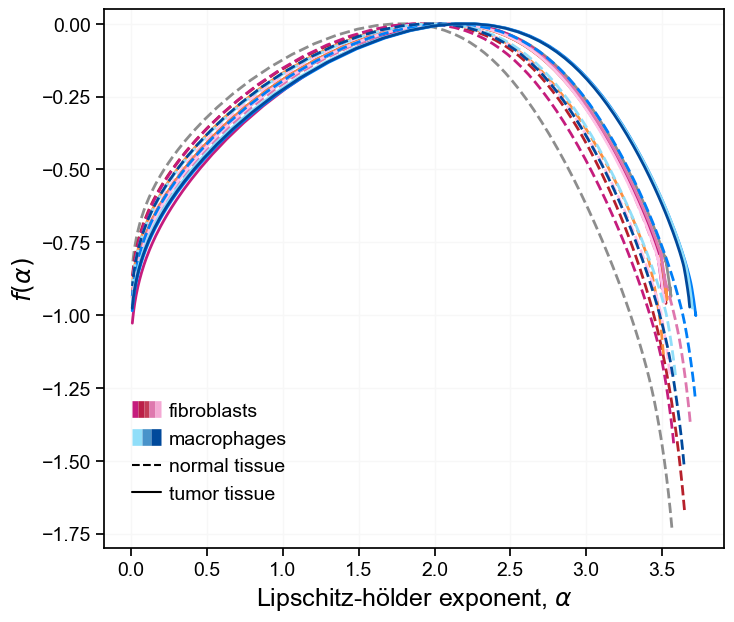

Figure saved: figure6a_multifractal_spectrum


In [ ]:
def plot_multifractal_spectrum(spectrum_df, marker_colors=None, figsize=(8, 5), ymin=-1.5, ymax=0.05): 
    # Default colors if none provided
    if marker_colors is None:
        marker_colors = {}
    
    # Color definitions for different cell types
    line_styles = {
        'Normal': '--', # Dashed for normal cells
        'Tumor': '-',   # Solid for tumor cells
    }
    
    # Create figure for plotting
    fig = plt.figure(figsize=figsize)
    legend_entries = OrderedDict()
    
    # Plot multifractal spectrum for each graph
    for _, row in spectrum_df.iterrows():
        # Set line style based on condition
        line_style = line_styles.get(row['tissue'], '-')
        
        # Get color based on cell type or use gray as default
        cell_type = row.get('celltype', 'unknown')
        color = marker_colors.get(cell_type, '#808080')
        
        # Plot spectrum
        line = plt.plot(
            row['holder_exponents'], 
            row['spectrum_values'], 
            linewidth=2, 
            alpha=1,
            color=color, 
            linestyle=line_style
        )[0]
        
        # Add to legend if it's a new type
        name_parts = row['graph_name'].split('_')
        legend_entries[name_parts[-1]] = line
    
    # Add legend and labels
    #plt.legend(legend_entries.values(), legend_entries.keys(), frameon=False, loc='upper left', bbox_to_anchor=(.3, .7), fontsize=16)


    # Create legend
    class GradientLine:
        pass

    # Create legend elements
    fib_line = GradientLine()
    mac_line = GradientLine()
    legend_elements = [
        fib_line,  # will be replaced by gradient
        mac_line,  # will be replaced by gradient
        Line2D([0], [0], marker='', linestyle='--', color='black', label='normal tissue',  markerfacecolor='white', markersize=10, markeredgecolor='black'),
        Line2D([0], [0], marker='', linestyle='-',color='black', label='tumor tissue',  markerfacecolor='white', markersize=12, markeredgecolor='black'),
    ]
    legend_labels = ['fibroblasts','macrophages', 'normal tissue', 'tumor tissue']
    
    # Get colors for gradients
    fib_colors = [marker_colors[m] for m in markers_F]
    mac_colors = [marker_colors[m] for m in markers_M]
    
    # Create handler map
    handler_map = { fib_line: GradientLineHandler(fib_colors, n_segments=len(fib_colors)+1),
                    mac_line: GradientLineHandler(mac_colors, n_segments=len(mac_colors)+1) }
    
    # Add legend to axis
    plt.legend(legend_elements, legend_labels,
                    handler_map=handler_map,
                    bbox_to_anchor=(0.02, 0.3),
                    loc='upper left',
                    frameon=False,
                    fontsize=14,
                    handletextpad=0.4,
                    borderpad=0.3,
                    handlelength=1.5,
                    alignment='left',
                    ncol=1)
    
    
    plt.xlabel('Lipschitz-hölder exponent, ' r'$\alpha$', fontsize=18)
    plt.ylabel(r'$f(\alpha)$', fontsize=18)
    #plt.title('Multifractal Spectrum')
    #plt.xlim(0,3.5)

    plt.ylim(ymin,ymax)
    plt.show()
    
    if resave_figures: save_figure(fig, 'figure6a_multifractal_spectrum')
    return fig


fig6a = plot_multifractal_spectrum(G_spectrums, marker_colors, figsize=(8, 7), ymin=-1.8, ymax=0.05)

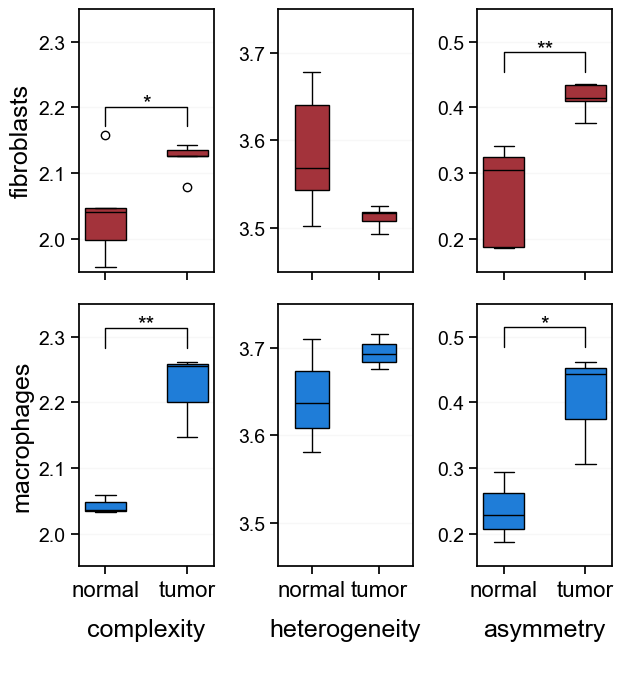

Figure saved: figure6b_multifractal_spectrum_properties


In [ ]:
def plot_combined_multifractal_metrics(spectrum_df_F, spectrum_df_M, 
                                      barcolor_F='blue', barcolor_M='red',
                                      marker_colors=None, figsize=(7, 8), 
                                      show_significance=True):
    
    # Set up a subplot grid with 2 rows and 3 columns
    fig, axs = plt.subplots(2, 3, figsize=figsize, facecolor='#fff')
    
    # Process both datasets
    datasets = [spectrum_df_F.copy(), spectrum_df_M.copy()]
    colors = [barcolor_F, barcolor_M]
    labels = ['fibroblasts', 'macrophages']
    
    for idx, (plot_df, color, label) in enumerate(zip(datasets, colors, labels)):
        # Calculate metrics if they're not already in the dataframe
        plot_df['alpha_0'] = plot_df.apply(
            lambda x: x['holder_exponents'][np.argmax(x['spectrum_values'])], axis=1)
        
        plot_df['width'] = plot_df.apply(
            lambda x: max(x['holder_exponents']) - min(x['holder_exponents']), axis=1)
        
        plot_df['asymmetry'] = plot_df.apply(lambda x: 
            np.log((x['holder_exponents'][np.argmax(x['spectrum_values'])] - min(x['holder_exponents'])) / 
                   (max(x['holder_exponents']) - x['holder_exponents'][np.argmax(x['spectrum_values'])])) 
            if len(x['holder_exponents']) > 0 else 0, 
            axis=1)
        
        # Plot 1: Alpha_0 by tissue type
        sns.boxplot(x='tissue', y='alpha_0', data=plot_df, ax=axs[idx, 0],  color=color, linecolor='black', width=0.5)
        axs[idx, 0].set_xlabel('')
        if idx == 0:
            axs[idx, 0].set_ylabel('fibroblasts', fontsize=18)
        else:
            axs[idx, 0].set_ylabel('macrophages', fontsize=18)
        axs[idx, 0].set_ylim(1.95, 2.35)
        axs[idx, 0].set_yticks([2, 2.1, 2.2, 2.3])
        # Properly set x-ticks before labels
        axs[idx, 0].set_xticks([0, 1])
        axs[idx, 0].set_xticklabels(['normal', 'tumor'], fontsize=16)
        
        # Plot 2: Spectrum width by tissue type
        sns.boxplot(x='tissue', y='width', data=plot_df, ax=axs[idx, 1],  color=color, linecolor='black', width=0.5)
        axs[idx, 1].set_xlabel('')
        axs[idx, 1].set_ylabel('')
        axs[idx, 1].set_ylim(3.45, 3.75)
        axs[idx, 1].set_yticks([3.5, 3.6, 3.7])
        # Properly set x-ticks before labels
        axs[idx, 1].set_xticks([0, 1])
        axs[idx, 1].set_xticklabels(['normal', 'tumor'], fontsize=16)
        
        # Plot 3: Asymmetry by tissue type
        sns.boxplot(x='tissue', y='asymmetry', data=plot_df, ax=axs[idx, 2],  color=color, linecolor='black', width=0.5)
        axs[idx, 2].set_xlabel('')
        axs[idx, 2].set_ylabel('')
        axs[idx, 2].set_ylim(0.15, 0.55)
        # Properly set x-ticks before labels
        axs[idx, 2].set_xticks([0, 1])
        axs[idx, 2].set_xticklabels(['normal', 'tumor'], fontsize=16)

        # Remove xtick labels for top row
        if idx == 0:
            axs[idx, 0].set_xticklabels([])
            axs[idx, 1].set_xticklabels([])
            axs[idx, 2].set_xticklabels([])
        
        # Add statistical significance if requested
        if show_significance and len(plot_df['tissue'].unique()) == 2:
            tissue_types = plot_df['tissue'].unique()
            
            # Function to convert p-values to stars
            def p_to_stars(p):
                if p < 0.001:
                    return '***'
                elif p < 0.01:
                    return '**'
                elif p < 0.05:
                    return '*'
                else:
                    return ''
            
            # Add significance for each metric
            metrics = ['alpha_0', 'width', 'asymmetry']
            
            for i, metric in enumerate(metrics):
                group1 = plot_df[plot_df['tissue'] == tissue_types[0]][metric]
                group2 = plot_df[plot_df['tissue'] == tissue_types[1]][metric]
                
                # Use t-test as in original
                stat, p_value = stats.ttest_ind(group1, group2, equal_var=True)
                
                # Add stars to the plots
                y_max = plot_df[metric].max() + plot_df[metric].std() * 0.2
                
                # Add p-value and significance bars
                x1, x2 = 0, 1  # positions of the boxes
                
                if p_to_stars(p_value) in ['***', '**', '*']:
                    axs[idx, i].plot([x1, x1, x2, x2], 
                                    [y_max, y_max + 0.03, y_max + 0.03, y_max], 
                                    lw=1, c='black')
                    axs[idx, i].text((x1 + x2) / 2, y_max + 0.02, 
                                    p_to_stars(p_value), 
                                    ha='center', va='bottom', color='black')
    
    if idx == 1:  # Only add title to bottom row, below the figure
        axs[idx, 0].set_title('complexity\n', fontsize=18, y=-0.4)
        axs[idx, 1].set_title('heterogeneity\n', fontsize=18, y=-0.4)
        axs[idx, 2].set_title('asymmetry\n', fontsize=18, y=-0.4)


    plt.tight_layout()
    plt.show()


    if resave_figures: save_figure(fig, 'figure6b_multifractal_spectrum_properties')
    
    return fig

fig6b = plot_combined_multifractal_metrics(G_spectrums_F, G_spectrums_M, 
                                  barcolor_F=marker_colors['CD73+'],
                                  barcolor_M=marker_colors['MARCO+'],
                                  figsize=(6.5, 7))

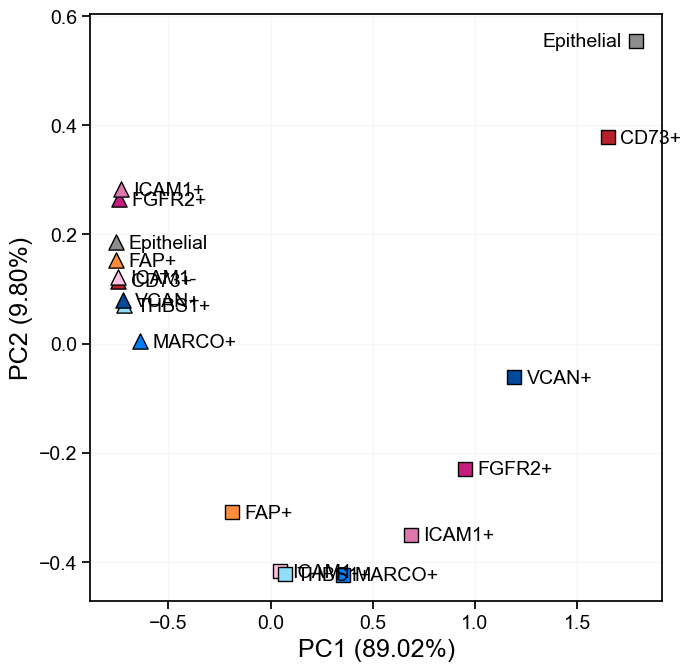

Figure saved: figure6c_pca_of_spectrum_distances


In [ ]:

def compute_pairwise_wasserstein_distances(spectrum_df, target_alpha=None, figsize=None): 

    if target_alpha is None:
        target_alpha = min(
            np.max(row['holder_exponents']) 
            for _, row in spectrum_df.iterrows()
        )
    
    extracted_values = []
    for _, row in spectrum_df.iterrows():
        holder_exponents = row['holder_exponents']
        spectrum_values = row['spectrum_values']
        
        closest_idx = np.argmin(np.abs(np.array(holder_exponents) - target_alpha))
        extracted_values.append(spectrum_values[closest_idx])
    
    n = len(spectrum_df)
    distance_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i + 1, n):
            dist = wasserstein_distance([extracted_values[i]], [extracted_values[j]])
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist
    
    distance_df = pd.DataFrame(
        distance_matrix, 
        index=spectrum_df['formatted_name'],  # Use formatted labels
        columns=spectrum_df['formatted_name']
    )
    if figsize is not None:
        plt_figure = plot_distance_heatmap(distance_df, target_alpha, figsize)
        plt_figure.show()
    return distance_df, extracted_values


def plot_pca_of_distance(distance_df, spectrum_df, marker_colors, figsize=(8, 6)):
    pca = PCA(n_components=3)
    embedded = pca.fit_transform(distance_df.values)

    # Extract cell type and sample type ('N' for normal, 'T' for tumor)
    labels = spectrum_df['formatted_name'].values
    cell_types = spectrum_df['celltype'].values
    sample_types = spectrum_df['tissue'].str[0].values  # 'N' for normal, 'T' for tumor

    # Define marker styles
    markers = {'N': 's', 'T': '^'}  # Normal = square, Tumor = triangle

    fig = plt.figure(figsize=figsize, facecolor='#fff')
        
    for i, label in enumerate(labels):
        cell_type = cell_types[i]
        sample_type = sample_types[i]  # 'N' or 'T'

        color = marker_colors.get(cell_type.split()[0], '#999999')  # Default gray if missing
        marker = markers.get(sample_type, 'o')  # Default circle if missing
        size = 90 if sample_type == 'N' else 120

        plt.scatter(
            embedded[i, 0], embedded[i, 1], 
            color=color, marker=marker, edgecolors='black', linewidth=1, s=size, 
            label=label if label not in plt.gca().get_legend_handles_labels()[1] else ""  # Avoid duplicate labels
        )

    for i, label in enumerate(labels):
        cell_type = cell_types[i]
        sample_type = sample_types[i]  # 'N' or 'T'

        color = marker_colors.get(cell_type.split()[0], '#999999')  # Default gray if missing
        marker = markers.get(sample_type, 'o')  # Default circle if missing

        # Annotate points with cell type labels
        if cell_type == 'Malignant': 
            cell_type = 'Epithelial'
        if cell_type == 'Epithelial' and sample_type == 'N':
            embedded[i, 0] -= 0.52  # Shift label right for clarity
        plt.text(
            embedded[i, 0] + 0.06, embedded[i, 1] - 0.002,  # Adjust text position slightly
            cell_type, fontsize=14, ha='left', va='center', 
        )

    plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
    plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")
    plt.tight_layout()

    plt.show()
    if resave_figures: save_figure(fig, 'figure6c_pca_of_spectrum_distances')
    return fig
    
pairwise_distances, extracted_alphas = compute_pairwise_wasserstein_distances(G_spectrums, target_alpha=5)
fig6c = plot_pca_of_distance(pairwise_distances, G_spectrums, marker_colors=marker_colors, figsize=(7.2, 7)) 
 


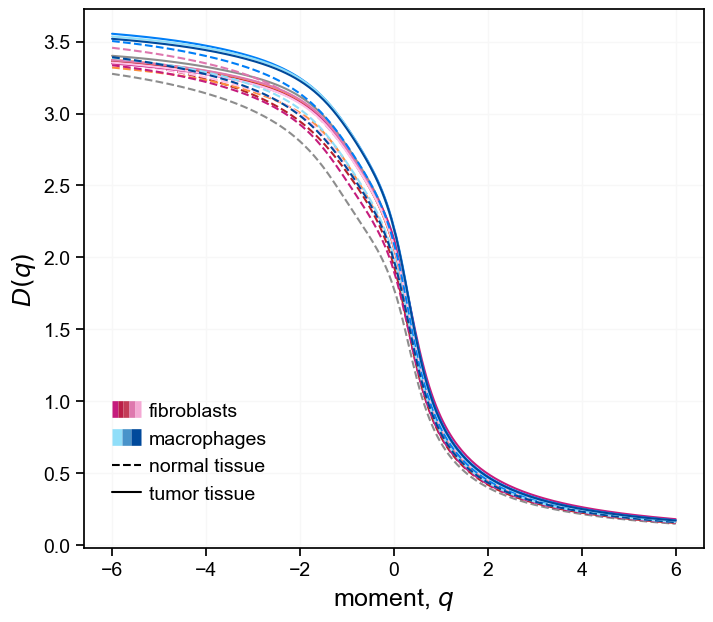

Figure saved: figure6d_generalized_fractal_dimension


In [ ]:

def plot_generalized_fractal_dimension(spectrum_df, moment_values, marker_colors=None, figsize=(8, 5)):
    # Default colors if none provided
    if marker_colors is None:
        marker_colors = {}
    
    # Color definitions for different tissue types
    line_styles = {
        'Normal': '--',  # Dashed for normal cells
        'Tumor': '-',    # Solid for tumor cells
    }
    
    # Create figure for plotting
    fig = plt.figure(figsize=figsize)
    legend_entries = OrderedDict()
    
    # Plot D(q) for each graph
    for _, row in spectrum_df.iterrows():
        if 'scaling_exponents' not in row:
            print(f"Warning: No scaling exponents found for {row['graph_name']}")
            continue
            
        tau_list = row['scaling_exponents']
        
        # Calculate D(q) = tau(q)/q for q ≠ 0
        q_values = []
        d_values = []
        
        for j, q in enumerate(moment_values):
            if q != 0:  # Avoid division by zero
                d_q = tau_list[j] / q
                q_values.append(q)
                d_values.append(d_q)
        
        # Set line style based on condition
        line_style = line_styles.get(row['tissue'], '-')
        
        # Get color based on cell type or use gray as default
        cell_type = row.get('celltype', 'unknown')
        color = marker_colors.get(cell_type, '#808080')
        
        # Plot D(q)
        line = plt.plot(
            q_values, 
            d_values, 
            linewidth=1.5, 
            alpha=1,
            color=color, 
            linestyle=line_style
        )[0]
    
    # Create legend
    class GradientLine:
        pass

    # Create legend elements
    fib_line = GradientLine()
    mac_line = GradientLine()
    legend_elements = [
        fib_line,  # will be replaced by gradient
        mac_line,  # will be replaced by gradient
        Line2D([0], [0], marker='', linestyle='--', color='black', label='normal tissue',  markerfacecolor='white', markersize=10, markeredgecolor='black'),
        Line2D([0], [0], marker='', linestyle='-',color='black', label='tumor tissue',  markerfacecolor='white', markersize=12, markeredgecolor='black'),
    ]
    legend_labels = ['fibroblasts','macrophages', 'normal tissue', 'tumor tissue']
    
    # Get colors for gradients
    fib_colors = [marker_colors[m] for m in markers_F]
    mac_colors = [marker_colors[m] for m in markers_M]
    
    # Create handler map
    handler_map = { fib_line: GradientLineHandler(fib_colors, n_segments=len(fib_colors)+1),
                    mac_line: GradientLineHandler(mac_colors, n_segments=len(mac_colors)+1) }
    
    # Add legend to axis
    plt.legend(legend_elements, legend_labels,
                    handler_map=handler_map,
                    bbox_to_anchor=(0.02, 0.3),
                    loc='upper left',
                    frameon=False,
                    fontsize=14,
                    handletextpad=0.4,
                    borderpad=0.3,
                    handlelength=1.5,
                    alignment='left',
                    ncol=1)
    
    #plt.xlabel('distorting exponent, ' r'$q$')
    plt.xlabel('moment, ' r'$q$')
    plt.ylabel(r'$D(q)$')
    #plt.title('Generalized Fractal Dimension')
    plt.grid(True)
    #plt.xlim(-5.5, 5.5)
    plt.show()

    if resave_figures: save_figure(fig, 'figure6d_generalized_fractal_dimension')
    return fig


fig6d = plot_generalized_fractal_dimension(G_spectrums, moment_values, marker_colors=marker_colors, figsize=(8, 7))   

Figure saved: figure6e_distance_heatmap


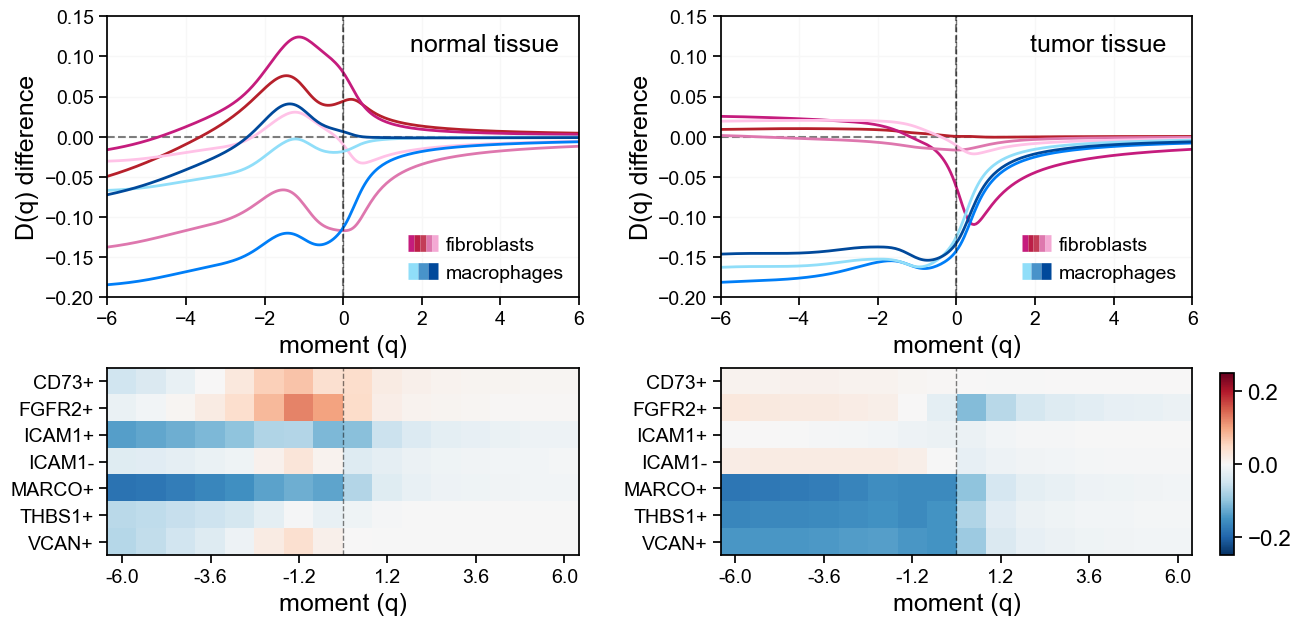

In [ ]:
def plot_combined_dimensions_and_heatmap(spectrum_df, moment_values, marker_colors=None, marker='FAP+', figsize=(18, 12)):
    
    # Extract marker data
    marker_data = spectrum_df[spectrum_df['celltype'] == marker]
    
    # Get cell types (excluding the marker)
    other_cell_types = [ct for ct in spectrum_df['celltype'].unique() if ct != marker]
    
    if len(other_cell_types) == 0 or len(marker_data) == 0:
        print("No data available for comparison")
        return
    
    # Create a figure with a 2x2 grid, adding extra space on the right for the colorbar
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(2, 2, width_ratios=[1, 1], height_ratios=[1.5, 1], wspace=0.3, hspace=0.3)
    
    # Define the axes for each subplot
    ax_normal_curves = fig.add_subplot(gs[0, 0])  # Top left - Normal curves
    ax_tumor_curves = fig.add_subplot(gs[0, 1])   # Top right - Tumor curves
    ax_normal_heatmap = fig.add_subplot(gs[1, 0]) # Bottom left - Normal heatmap
    ax_tumor_heatmap = fig.add_subplot(gs[1, 1])  # Bottom right - Tumor heatmap
    
    # Map tissue types to axes
    tissue_axes_map = {
        'Normal': {'curves': ax_normal_curves, 'heatmap': ax_normal_heatmap},
        'Tumor': {'curves': ax_tumor_curves, 'heatmap': ax_tumor_heatmap}
    }
    
    # Process each tissue type (Normal and Tumor)
    for tissue, axes_dict in tissue_axes_map.items():    
        ax_curves = axes_dict['curves']
        ax_heatmap = axes_dict['heatmap']
        
        # Get marker data for this tissue
        marker_tissue = marker_data[marker_data['tissue'] == tissue]
        
        if len(marker_tissue) == 0:
            ax_curves.text(0.5, 0.5, f"No {marker} data for {tissue}", 
                         ha='center', va='center', transform=ax_curves.transAxes)
            ax_heatmap.text(0.5, 0.5, f"No {marker} data for {tissue}", 
                         ha='center', va='center', transform=ax_heatmap.transAxes)
            continue
        
        # Use the first row for the marker
        marker_tau = marker_tissue.iloc[0]['scaling_exponents']
        
        # Calculate D(q) for marker
        marker_dq = []
        q_vals = []
        for j, q in enumerate(moment_values):
            if q != 0 and j < len(marker_tau):  # Avoid division by zero
                q_vals.append(q)
                marker_dq.append(marker_tau[j] / q)
        
        # ----- CURVE PLOT -----
        # Comparison lines at x=0 and y=0
        ax_curves.axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
        ax_curves.axvline(x=0, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
        
        # Compare with each other cell type
        for other_marker in other_cell_types:
            # Get data for this cell type and tissue
            other_marker_data = spectrum_df[(spectrum_df['celltype'] == other_marker) & 
                                  (spectrum_df['tissue'] == tissue)]
            
            if len(other_marker_data) == 0:
                continue
            
            # Use the first row for this cell type
            other_marker_tau = other_marker_data.iloc[0]['scaling_exponents']
            
            # Calculate D(q) for this cell type
            cell_dq = []
            for j, q in enumerate(moment_values):
                if q != 0 and j < len(other_marker_tau) and j < len(marker_tau):  # Ensure indices match
                    cell_dq.append(other_marker_tau[j] / q)
            
            # Calculate the difference
            if len(cell_dq) == len(marker_dq):
                diff_dq = np.array(marker_dq) - np.array(cell_dq)
                
                # Plot the difference
                ax_curves.plot(q_vals, diff_dq, 
                             linewidth=2, color=marker_colors.get(other_marker, 'gray'),
                             label=f"{other_marker}")
        
        # Set limits
        ax_curves.set_xlim(-6, 6)
        ax_curves.set_ylim(-0.2, 0.15)
        
        # Add labels
        ax_curves.set_title(f"{tissue.lower()} tissue\n", y=.75, x=.8, fontsize=18)
        ax_curves.set_ylabel('D(q) difference')
        ax_curves.set_xlabel('moment (q)')
        ax_curves.grid(True)
        
        # Create legend
        class GradientLine:
            pass

        # Create legend elements
        fib_line = GradientLine()
        mac_line = GradientLine()
        legend_elements = [
            fib_line,  # will be replaced by gradient
            mac_line,  # will be replaced by gradient
            #Line2D([0], [0], marker='', linestyle='--', color='black', label='normal tissue',  markerfacecolor='white', markersize=10, markeredgecolor='black'),
            #Line2D([0], [0], marker='', linestyle='-',color='black', label='tumor tissue',  markerfacecolor='white', markersize=12, markeredgecolor='black'),
        ]
        legend_labels = ['fibroblasts','macrophages', 'normal tissue', 'tumor tissue']
        
        # Get colors for gradients
        fib_colors = [marker_colors[m] for m in markers_F]
        mac_colors = [marker_colors[m] for m in markers_M]
        
        # Create handler map
        handler_map = { fib_line: GradientLineHandler(fib_colors, n_segments=len(fib_colors)+1),
                        mac_line: GradientLineHandler(mac_colors, n_segments=len(mac_colors)+1) }
        
        # Add legend to axis
        ax_curves.legend(legend_elements, legend_labels,
                        handler_map=handler_map,
                        #bbox_to_anchor=(0.02, 0.3),
                        loc='lower right',
                        frameon=False,
                        fontsize=14,
                        handletextpad=0.4,
                        borderpad=0.3,
                        handlelength=1.5,
                        alignment='left',
                        ncol=1)
            



        
        # ----- HEATMAP PLOT -----
        # Select a subset of q values for clearer visualization
        q_indices = list(range(0, len(moment_values), len(moment_values)//15))
        selected_qs = [moment_values[i] for i in q_indices if moment_values[i] != 0]
        
        # Prepare data for heatmap
        diff_matrix = []
        other_marker_labels = []
        
        # Compare with each other cell type
        for other_marker in other_cell_types:
            # Get data for this cell type and tissue
            other_marker_data = spectrum_df[(spectrum_df['celltype'] == other_marker) & 
                                   (spectrum_df['tissue'] == tissue)]
            
            if len(other_marker_data) == 0:
                continue
            
            # Use the first row for this cell type
            cell_tau = other_marker_data.iloc[0]['scaling_exponents']
            
            # Calculate differences for selected q values
            diff_row = []
            for q_idx in q_indices:
                q = moment_values[q_idx]
                if q != 0 and q_idx < len(cell_tau) and q_idx < len(marker_tau):
                    diff = (marker_tau[q_idx] / q) - (cell_tau[q_idx] / q)
                    diff_row.append(diff)
                else:
                    diff_row.append(np.nan)
            
            if len(diff_row) > 0:
                diff_matrix.append(diff_row)
                other_marker_labels.append(other_marker)
        
        if not diff_matrix:
            ax_heatmap.text(0.5, 0.5, f"No comparison data for {tissue}", 
                          ha='center', va='center', transform=ax_heatmap.transAxes)
            continue
        
        # Convert to numpy array for heatmap
        diff_array = np.array(diff_matrix)
        
        # Create heatmap
        im = ax_heatmap.imshow(diff_array, cmap='RdBu_r', aspect='auto', 
                              vmin=-0.25, vmax=0.25)  # Symmetric color scale
        
        # Store the heatmap image object for later colorbar creation
        if tissue == 'Tumor':
            heatmap_img = im
        
        # Add dividing lines for negative and positive q values (dotted vertical lines)
        ax_curves.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
        ax_heatmap.axvline(x=len(selected_qs)//2-0.5, color='black', linestyle='--', linewidth=1, alpha=0.5)
        
        # Set labels
        ax_heatmap.set_yticks(range(len(other_marker_labels)))
        ax_heatmap.set_yticklabels(other_marker_labels)
        
        # Set x-axis labels (q values)
        selected_indices = list(range(0, len(selected_qs), len(selected_qs)//5))
        ax_heatmap.set_xticks(selected_indices)
        ax_heatmap.set_xticklabels([f"{selected_qs[i]:.1f}" for i in selected_indices], rotation=0)
        ax_heatmap.set_xlabel('moment (q)')
        
        ax_heatmap.grid(False)
     
    
    # Create colorbar on the far right of the figure, spanning the full height of the heatmaps
    cbar_ax = fig.add_axes([0.92, 0.11, 0.01, 0.26])  # [left, bottom, width, height]
    
    # Add the colorbar using the tumor heatmap
    if 'heatmap_img' in locals():
        cbar = fig.colorbar(heatmap_img, cax=cbar_ax)
        cbar.set_label('', fontsize=14, rotation=270, labelpad=15)
        cbar.ax.tick_params(labelsize=16)
    

    if resave_figures: save_figure(fig, 'figure6e_distance_heatmap')
    return 

# Example usage:
fig6e = plot_combined_dimensions_and_heatmap(G_spectrums_FM, moment_values, marker_colors=marker_colors, marker='FAP+', figsize=(14, 7))

In [11]:
def analyze_marker_comparison(G_list, G_names, marker_name, topn=50):  
    # Find the indices for Normal and Tumor graphs for this marker
    normal_pattern = f"_Normal_{marker_name}"
    tumor_pattern = f"_Tumor_{marker_name}"
    
    normal_idx = None
    tumor_idx = None
    
    for i, name in enumerate(G_names):
        if normal_pattern in name:
            normal_idx = i
        if tumor_pattern in name:
            tumor_idx = i
    
    if normal_idx is None or tumor_idx is None:
        raise ValueError(f"Could not find both Normal and Tumor graphs for marker {marker_name}")
    
    # Extract the relevant graphs and names
    selected_G_list = [G_list[normal_idx], G_list[tumor_idx]]
    selected_G_names = [G_names[normal_idx], G_names[tumor_idx]]
    
    print(f"Comparing: {selected_G_names[0]} vs {selected_G_names[1]}")
    
    # Run the analysis on the selected graphs
    reaction_curvatures, reaction_comparisons, metabolite_names = calculate_curvatures(selected_G_list, selected_G_names)
      
    return {
        'reaction_curvatures': reaction_curvatures,
        'reaction_comparisons': reaction_comparisons,
        'metabolite_names': metabolite_names, 
    }


def calculate_curvatures(G_list, G_names): 
    if len(G_list) != 2 or len(G_names) != 2:
        raise ValueError("This function requires exactly two graphs to compare")
    
    reaction_curvatures = {name: {} for name in G_names}
    metabolite_names = {}  # To store MetaboliteID -> MetaboliteName mappings
    
    # Process each graph
    for G, name in zip(G_list, G_names):
        # Create a simplified graph for curvature calculation
        simple_G = nx.DiGraph()
        
        # Track original metabolite IDs and names
        for node, data in G.nodes(data=True):
            metabolite_id = data.get('MetaboliteID', str(node))
            metabolite_name = data.get('MetaboliteName', metabolite_id)
            
            # Store mapping from ID to Name
            metabolite_names[metabolite_id] = metabolite_name
            
            simple_G.add_node(node, MetaboliteID=metabolite_id, MetaboliteName=metabolite_name)
        
        # Process edges by reaction
        reactions_data = {}  # ReactionID -> details
        
        for u, v, key, data in G.edges(data=True, keys=True):
            source_metab_id = G.nodes[u].get('MetaboliteID', str(u))
            target_metab_id = G.nodes[v].get('MetaboliteID', str(v))
            metab_pair = (source_metab_id, target_metab_id)
            
            weight = data.get('weight')
            reaction_id = data.get('ReactionID')
            reaction_name = data.get('ReactionName')

            # Initialize reaction data if not already present
            if reaction_id not in reactions_data:
                reactions_data[reaction_id] = {
                    'edges': [],
                    'reaction_name': reaction_name,
                    'total_weight': 0
                }
            
            reactions_data[reaction_id]['edges'].append((u, v, weight, metab_pair))
            reactions_data[reaction_id]['total_weight'] += weight
        
        # Add edges to simple graph, organized by reaction
        for reaction_id, reaction_info in reactions_data.items():
            for u, v, weight, metab_pair in reaction_info['edges']:
                # Add the edge with its weight and metadata
                if simple_G.has_edge(u, v):
                    # If edge already exists, update it
                    edge_data = simple_G[u][v]
                    if 'reactions' not in edge_data:
                        edge_data['reactions'] = []
                        edge_data['reaction_names'] = []
                        edge_data['reaction_weights'] = {}
                        edge_data['metabolite_pairs'] = []
                    
                    edge_data['weight'] += weight
                    edge_data['reactions'].append(reaction_id)
                    edge_data['reaction_names'].append(reaction_info['reaction_name'])
                    edge_data['reaction_weights'][reaction_id] = weight
                    if metab_pair not in edge_data['metabolite_pairs']:
                        edge_data['metabolite_pairs'].append(metab_pair)
                else:
                    # Create a new edge
                    simple_G.add_edge(u, v, weight=weight, 
                                    reactions=[reaction_id],
                                    reaction_names=[reaction_info['reaction_name']],
                                    reaction_weights={reaction_id: weight},
                                    metabolite_pairs=[metab_pair])
        
        # Compute curvature on the simplified graph
        G_int = nx.convert_node_labels_to_integers(simple_G)
        
        # Create mapping from old to new node labels
        node_map = {old: new for new, old in enumerate(simple_G.nodes())}
        
        # Create reverse mapping from new to old node labels
        reverse_node_map = {new: old for old, new in node_map.items()}
        
        # Compute Ricci curvature
        orc = OllivierRicci(G_int, alpha=0.5, verbose="ERROR", weight='weight')
        orc.compute_ricci_curvature()
        G_orc = orc.G.copy()
        
        # Map curvatures back to reactions
        for u, v, d in G_orc.edges(data=True):
            # Get original nodes
            orig_u = reverse_node_map[u]
            orig_v = reverse_node_map[v]
            
            # Get original edge data
            orig_edge_data = simple_G[orig_u][orig_v]
            
            # Store curvature for each reaction in this edge
            for i, reaction_id in enumerate(orig_edge_data['reactions']):
                reaction_name = orig_edge_data['reaction_names'][i]
                weight = orig_edge_data['reaction_weights'][reaction_id]
                metab_pairs = orig_edge_data['metabolite_pairs']
                
                reaction_curvatures[name][reaction_id] = {
                    'curvature': d['ricciCurvature'],
                    'weight': weight,
                    'reaction_name': reaction_name,
                    'metabolite_pairs': metab_pairs,
                    'source_node': orig_u,
                    'target_node': orig_v
                }
    
    # Compare reactions between graphs
    g1_name, g2_name = G_names
    g1_reactions = set(reaction_curvatures[g1_name].keys())
    g2_reactions = set(reaction_curvatures[g2_name].keys())
    
    # Find common reactions
    common_reactions = g1_reactions.intersection(g2_reactions)
    
    # Calculate differences for common reactions
    reaction_comparisons = {}
    for reaction_id in common_reactions:
        g1_data = reaction_curvatures[g1_name][reaction_id]
        g2_data = reaction_curvatures[g2_name][reaction_id]
        
        curvature_diff = g1_data['curvature'] - g2_data['curvature']  # Not abs() to preserve direction
        abs_diff = abs(curvature_diff)

        # For log fold change calculation
        if g2_data['curvature'] != 0 and g1_data['curvature'] != 0:
            # If signs are the same, use conventional log fold change
            if (g1_data['curvature'] * g2_data['curvature']) > 0:
                abslog2foldchange = abs(np.log2(abs(g1_data['curvature']) / abs(g2_data['curvature']))) 
            else:
                # If signs differ, this represents a significant change in network property
                # Could use a special value or a custom metric
                abslog2foldchange = float('inf') if g1_data['curvature'] > 0 else float('-inf')
        else:
            abslog2foldchange = float('nan')
        
        # Get all metabolite pairs involved in this reaction
        all_metab_pairs = set()
        all_metab_pairs.update(g1_data['metabolite_pairs'])
        all_metab_pairs.update(g2_data['metabolite_pairs'])
        
        # Format metabolite pairs for display
        formatted_pairs = []
        for source_id, target_id in all_metab_pairs:
            source_name = metabolite_names.get(source_id, source_id)
            target_name = metabolite_names.get(target_id, target_id)
            formatted_pairs.append(f"{source_name} → {target_name}")
        
        reaction_comparisons[reaction_id] = {
            'reaction_name': g1_data['reaction_name'],  # Use name from first graph
            f"{g1_name}_curvature": g1_data['curvature'],
            f"{g2_name}_curvature": g2_data['curvature'],
            'curvature_difference': curvature_diff,
            'absolute_difference': abs_diff,
            'abslog2foldchange': abslog2foldchange,
            f"{g1_name}_weight": g1_data['weight'],
            f"{g2_name}_weight": g2_data['weight'],
            'metabolite_pairs': formatted_pairs
        }
    
    # Add unique reactions to the comparison
    for reaction_id in g1_reactions - g2_reactions:
        g1_data = reaction_curvatures[g1_name][reaction_id]
        
        # Format metabolite pairs for display
        formatted_pairs = []
        for source_id, target_id in g1_data['metabolite_pairs']:
            source_name = metabolite_names.get(source_id, source_id)
            target_name = metabolite_names.get(target_id, target_id)
            formatted_pairs.append(f"{source_name} → {target_name}")
        
        reaction_comparisons[reaction_id] = {
            'reaction_name': g1_data['reaction_name'],
            f"{g1_name}_curvature": g1_data['curvature'],
            f"{g2_name}_curvature": float('nan'),  # Not present in g2
            'curvature_difference': g1_data['curvature'],  # Difference is just g1's value
            'absolute_difference': abs(g1_data['curvature']),
            'abslog2foldchange': float('nan'),  # Not applicable
            f"{g1_name}_weight": g1_data['weight'],
            f"{g2_name}_weight": 0.0,  # Not present in g2
            'metabolite_pairs': formatted_pairs,
            'unique_to': g1_name
        }
    
    for reaction_id in g2_reactions - g1_reactions:
        g2_data = reaction_curvatures[g2_name][reaction_id]
        
        # Format metabolite pairs for display
        formatted_pairs = []
        for source_id, target_id in g2_data['metabolite_pairs']:
            source_name = metabolite_names.get(source_id, source_id)
            target_name = metabolite_names.get(target_id, target_id)
            formatted_pairs.append(f"{source_name} → {target_name}")
        
        reaction_comparisons[reaction_id] = {
            'reaction_name': g2_data['reaction_name'],
            f"{g1_name}_curvature": float('nan'),  # Not present in g1
            f"{g2_name}_curvature": g2_data['curvature'],
            'curvature_difference': -g2_data['curvature'],  # Negative of g2's value
            'absolute_difference': abs(g2_data['curvature']),
            'abslog2foldchange': float('nan'),  # Not applicable
            f"{g1_name}_weight": 0.0,  # Not present in g1
            f"{g2_name}_weight": g2_data['weight'],
            'metabolite_pairs': formatted_pairs,
            'unique_to': g2_name
        }
    
    return reaction_curvatures, reaction_comparisons, metabolite_names

In [12]:
results_FAP = analyze_marker_comparison(G_list, G_names, 'FAP+')
results_MARCO = analyze_marker_comparison(G_list, G_names, 'MARCO+')

Comparing: Fibroblast_Normal_FAP+ vs Fibroblast_Tumor_FAP+
Comparing: Macrophage_Normal_MARCO+ vs Macrophage_Tumor_MARCO+


In [ ]:
def plot_ricci_curvature_scatter(reaction_comparisons, G_names, binary_rxns_df, subsystem_colors, 
                                top_n=None, highlight_top=30, marker_name='', figsize=(8, 8), 
                                exclude_transport=True): 
    # Extract the two condition names from the reaction comparisons
    condition_keys = []
    for reaction_data in next(iter(reaction_comparisons.values())).keys():
        if reaction_data.endswith('_curvature'):
            condition_keys.append(reaction_data)
    
    condition_keys = condition_keys[:2]  # Only use the first two
    
    if len(condition_keys) != 2:
        raise ValueError(f"Expected exactly 2 condition keys, found {len(condition_keys)}: {condition_keys}")
    
    # Extract the condition names (remove '_curvature' suffix)
    normal_name = condition_keys[0].replace('_curvature', '')
    tumor_name = condition_keys[1].replace('_curvature', '')
    
    print(f"Comparing curvatures between: {normal_name} and {tumor_name}")
    
    # Sort reactions by absolute difference using vectorized operations
    sorted_reactions = sorted(reaction_comparisons.items(), 
                             key=lambda x: x[1].get('abslog2foldchange', 0) 
                             if not np.isnan(x[1].get('abslog2foldchange', 0)) else 0, 
                             reverse=True)
    
    # Limit to top_n if specified
    if top_n is not None:
        sorted_reactions = sorted_reactions[:top_n]
    
    # Prepare data points and additional metadata using list comprehensions
    reaction_data = [(reaction_id, data) for reaction_id, data in sorted_reactions 
                    if 'unique_to' not in data]
    
    # Create a dictionary for quick subsystem lookup
    subsystem_dict = dict(zip(binary_rxns_df['Reactions'], binary_rxns_df['subSystems']))
    
    # Filter out transport reactions if requested
    if exclude_transport:
        reaction_data = [(reaction_id, data) for reaction_id, data in reaction_data 
                        if 'transport' not in subsystem_dict.get(reaction_id, '').lower()]
        print(f"Excluded transport reactions. Remaining reactions: {len(reaction_data)}")
    
    # Create a dictionary for quick color lookup
    color_dict = {}
    for _, row in subsystem_colors.iterrows():
        color_value = row['Color']
        
        # Handle color values that might be stored as strings or tuples
        if isinstance(color_value, str) and color_value.startswith('(') and color_value.endswith(')'):
            try:
                color_tuple = eval(color_value)
                if len(color_tuple) in [3, 4]:
                    color_value = color_tuple
            except:
                color_value = '#808080'
                
        color_dict[row['Subsystem']] = color_value
    
    # Default color for unknown subsystems
    default_color = '#808080'  # Gray
     
    # Extract data for plotting
    reaction_ids = [r_id for r_id, _ in reaction_data]
    labels = [data.get('reaction_name', r_id) for r_id, data in reaction_data]
    subsystems = [subsystem_dict.get(r_id, 'Unknown') for r_id in reaction_ids]
    
    # Get the raw curvature values
    x_values_raw = [data[condition_keys[1]] for _, data in reaction_data] # Tumor
    y_values_raw = [data[condition_keys[0]] for _, data in reaction_data] # Normal
    
    # Store the signs for analysis but use absolute values for plotting
    x_signs = [1 if x >= 0 else -1 for x in x_values_raw]
    y_signs = [1 if y >= 0 else -1 for y in y_values_raw]
    
    # Calculate absolute values for plotting
    x_values = [abs(x) for x in x_values_raw]
    y_values = [abs(y) for y in y_values_raw]
    
    # Calculate fold changes for each point (with proper handling of zeros)
    fold_changes = []
    for x, y in zip(x_values, y_values):
        if x != 0 and y != 0:
            # Calculate absolute log2 fold change
            fold_changes.append(abs(np.log2(y / x)))
        else:
            # Handle special cases with zeros
            if x == 0 and y == 0:
                fold_changes.append(0)  # No change when both are zero
            else:
                fold_changes.append(float('inf'))  # Infinite change when one is zero
    
    # Get indices of points sorted by fold change
    fold_change_sorted_indices = sorted(range(len(fold_changes)), key=lambda i: fold_changes[i], reverse=True)
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Add diagonal line (y=x) representing no change
    ax.plot([10**-5, 10**5], [10**-5, 10**5], 'k--', alpha=0.5, label='No Change')
    
    # Prepare colors for each point based on subsystem
    point_colors = [color_dict.get(subsystem, default_color) for subsystem in subsystems]
    
    # Plot all points as a scatter plot with subsystem-based colors
    scatter = ax.scatter(x_values, y_values, marker='s',
                         alpha=0.2, s=50, c=point_colors, edgecolors='white', linewidth=0.1)
    
    # Highlight points with highest fold changes
    highlight_indices = fold_change_sorted_indices[:highlight_top]
    
    # Highlight selected reactions with black edges
    for i in highlight_indices:
        if i < len(x_values) and i < len(y_values):
            ax.scatter(x_values[i], y_values[i], marker='s',
                      alpha=1, s=100, c=point_colors[i], edgecolors='black', linewidth=1)
    
    
    # Set labels and title
    ax.set_xlabel(f'|Ricci curvature| in tumor tissue', fontsize=18)
    ax.set_ylabel(f'|Ricci curvature| in normal tissue', fontsize=18)
    
    # Make plot logarithmic with positive values only
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    
    # Set grid
    ax.grid(True)
    
    plt.tight_layout()
    
    # Create DataFrame of highlighted reactions
    highlighted_data = [
        {
            'ReactionID': reaction_ids[i],
            'ReactionName': labels[i],
            'Subsystem': subsystems[i],
            f'{normal_name}_curvature': x_values_raw[i],  # Use raw values for the dataframe
            f'{tumor_name}_curvature': y_values_raw[i],   # Use raw values for the dataframe
            'CurvatureDifference': y_values_raw[i] - x_values_raw[i],
            'SignChange': x_signs[i] != y_signs[i],  # Flag if the sign changed
            'FoldChange': fold_changes[i],
            'CurvatureAbsLog2FoldChange': fold_changes[i]
        }
        for i in highlight_indices
    ]

    # Add marker name to the top left corner
    if marker_name:
        celltype = ''
        if 'FAP' in marker_name:
            celltype = 'fibroblasts'
            x = 0.05
            y = 0.95

        elif 'MARCO' in marker_name:
            celltype = 'macrophages'
            x = 0.5
            y = 0.08
            ax.set_ylabel('')
            
    ax.text(x, y, marker_name + ' ' + celltype, transform=ax.transAxes, fontsize=18, verticalalignment='top', horizontalalignment='left')
    
    highlighted_reactions_df = pd.DataFrame(highlighted_data).sort_values(by='CurvatureAbsLog2FoldChange', ascending=False)
    
    if resave_figures: save_figure(fig, 'figure6f_ricci_curvature_scatter_' + marker_name)
    
    return fig, highlighted_reactions_df

Comparing curvatures between: Fibroblast_Normal_FAP+ and Fibroblast_Tumor_FAP+
Excluded transport reactions. Remaining reactions: 3243
Figure saved: figure6f_ricci_curvature_scatter_FAP+


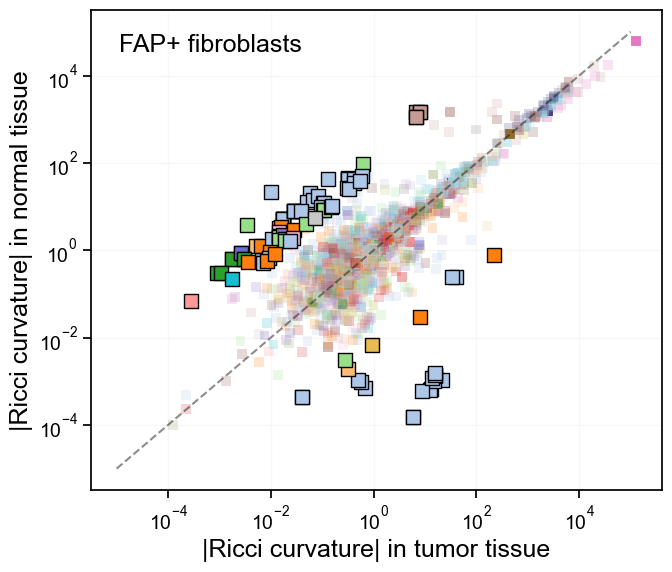

In [145]:
# Load subsystem_colors from dict
import json
with open('subsystem_colors.json', 'r') as f:
    subsystem_colors = json.load(f)

#convert subsystem_colors to df
subsystem_colors = pd.DataFrame(list(subsystem_colors.items()), columns=['Subsystem', 'Color'])


figure6f1, highlighted_reactions_df_FAP = plot_ricci_curvature_scatter(results_FAP['reaction_comparisons'],
                                                                        G_names,
                                                                        DATA['binary_rxns'],
                                                                        subsystem_colors,
                                                                        highlight_top=100,
                                                                        marker_name='FAP+',
                                                                        figsize=(7, 6)
                                                                )

Comparing curvatures between: Macrophage_Normal_MARCO+ and Macrophage_Tumor_MARCO+
Excluded transport reactions. Remaining reactions: 3448
Figure saved: figure6f_ricci_curvature_scatter_MARCO+


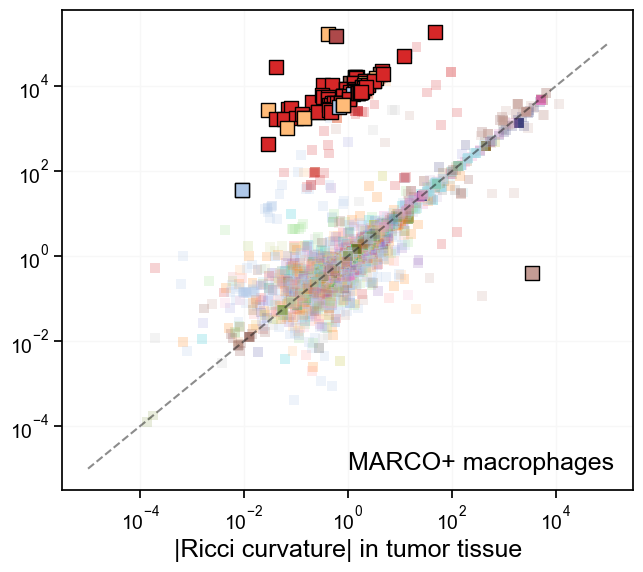

In [146]:
figure6f2, highlighted_reactions_df_MARCO = plot_ricci_curvature_scatter(results_MARCO['reaction_comparisons'],
                                                                        G_names,
                                                                        DATA['binary_rxns'],
                                                                        subsystem_colors,
                                                                        highlight_top=100,
                                                                        marker_name='MARCO+',
                                                                        figsize=(7, 6)
                                                                )


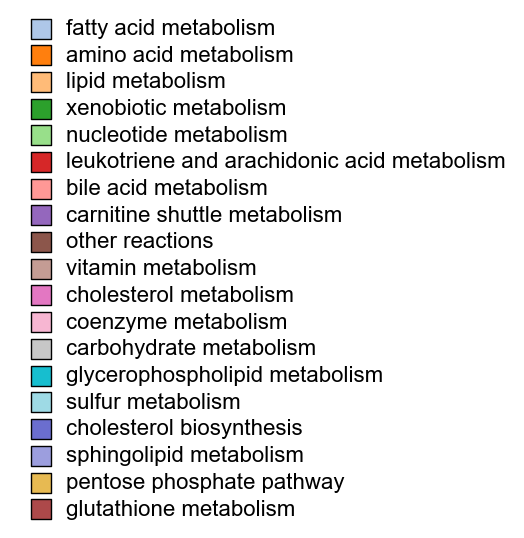

Figure saved: figure6f_ricci_curvature_scatter_legend


In [ ]:
# Create legend figure from subsystem_colors
def create_legend_from_subsystem_colors(subsystem_colors, figsize=(8, 6)):
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create a color legend
    for i, (subsystem, color) in enumerate(zip(subsystem_colors['Subsystem'], subsystem_colors['Color'])):
        ax.scatter([], [], color=color, label=subsystem, s=200, marker='s', edgecolors='black', linewidth=1)
    
    # Set distance between legend entries
    ax.legend(loc='center', fontsize=16, frameon=False, labelspacing=.3, handletextpad=.1)
    ax.axis('off')  # Hide axes
    plt.show()
    if resave_figures: save_figure(fig, 'figure6f_ricci_curvature_scatter_legend')
    
    return fig


highlighted_reactions_df = pd.concat([highlighted_reactions_df_FAP, highlighted_reactions_df_MARCO], ignore_index=True)
figure6f3 = create_legend_from_subsystem_colors(subsystem_colors[subsystem_colors['Subsystem'].isin(highlighted_reactions_df['Subsystem'].unique())], figsize=(4, 4))

Figure saved: Figure6_Graph_Geometry


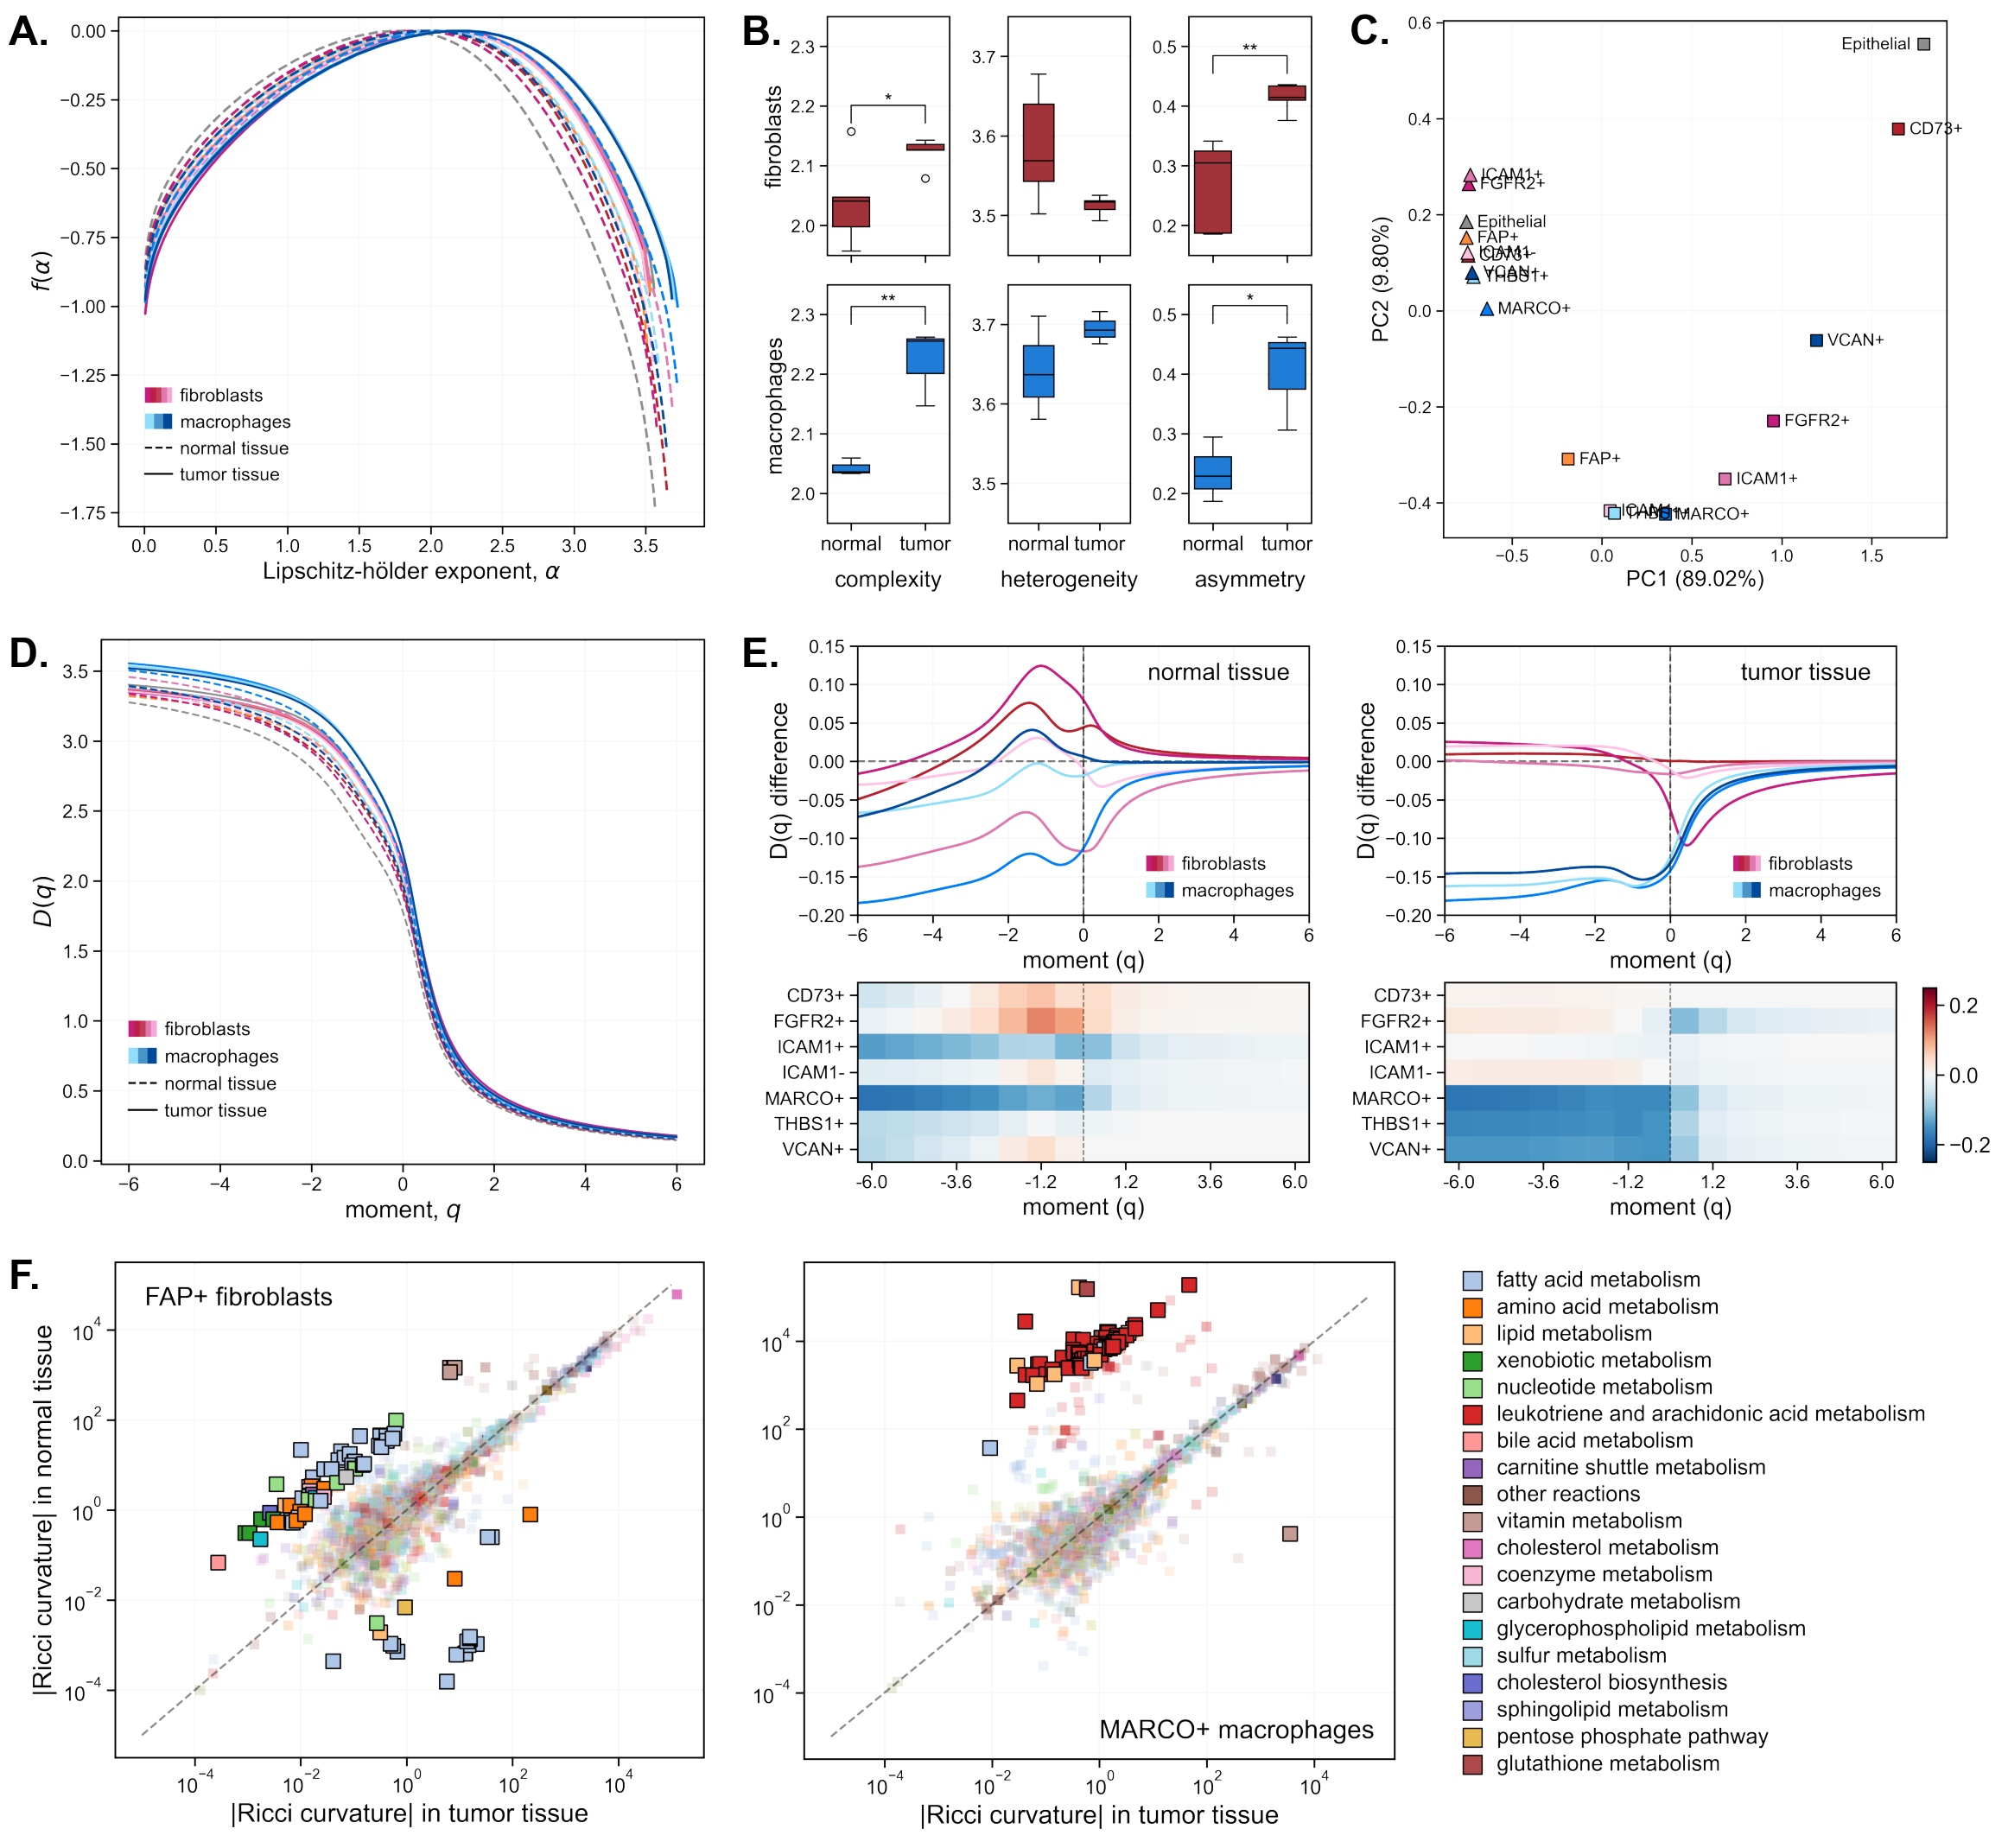

In [160]:
fig = plt.figure(figsize=(16, 16))
def add_panel(image_path, xyw, label=None, z=1):
    x, y, w = xyw
    # Read image to get aspect ratio
    img = mpimg.imread(image_path)
    img_h, img_w = img.shape[:2]
    aspect_ratio = img_h / img_w
    h = w * aspect_ratio  # scale height to keep image ratio
    bottom = 1 - y - h # Convert y from top-left origin to bottom-left origin
    ax = fig.add_axes([x, bottom, w, h], zorder=z)
    ax.imshow(img)
    ax.axis("off")
    if label:
        fig.text(x-0.01, bottom + h -0.005, label +'. ', fontsize=34, ha='left', va='top', fontweight='bold')


add_panel("../figures/png/figure6a_multifractal_spectrum.png",            [0, 0, 0.5], "A")
add_panel("../figures/png/figure6b_multifractal_spectrum_properties.png", [0.53, 0, 0.41], "B")
add_panel("../figures/png/figure6c_pca_of_spectrum_distances.png",        [.97, 0, 0.44], "C")

add_panel("../figures/png/figure6d_generalized_fractal_dimension.png",    [0, 0.45, 0.5], "D")
add_panel("../figures/png/figure6e_distance_heatmap.png",                 [0.53, 0.45, 0.9], "E") 

add_panel("../figures/png/figure6f_ricci_curvature_scatter_FAP+.png",     [0, .9, 0.5], "F")
add_panel("../figures/png/figure6f_ricci_curvature_scatter_MARCO+.png",   [0.52, .9, 0.48], "")
add_panel("../figures/png/figure6f_ricci_curvature_scatter_legend.png",   [1.02, .9, 0.37], "")


if resave_figures: save_figure(fig, 'Figure6_Graph_Geometry')